In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from fleck import Star, generate_spots
import astropy.units as u
from scipy.optimize import fmin_powell, fmin_l_bfgs_b
from celerite import terms, GP
from celerite.modeling import Model

In [42]:
names = ['BJD_TDB', 'flux', 'err', 'visit', 'orbit', 'spatial_scan']
vis12 = Table.read('data/whitelc_vis12.txt', format='ascii', delimiter=' ', 
                   names=names)
vis13 = Table.read('data/whitelc_vis13.txt', format='ascii', delimiter=' ',
                   names=names)

In [43]:
from batman import TransitModel, TransitParams

p = TransitParams()
p.per = 1.58040464894
p.t0 = 2455320.535733
p.inc = 89.1
p.a = 15.23
p.w = 90
p.ecc = 0
p.u = [0.28]
p.limb_dark = 'linear'
p.rp = 0.013490**0.5

Optimization terminated successfully.
         Current function value: -483.428089
         Iterations: 10
         Function evaluations: 1286


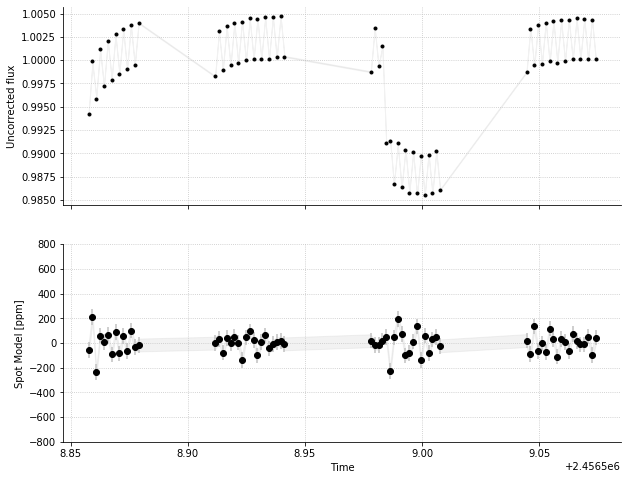

Optimization terminated successfully.
         Current function value: -515.324054
         Iterations: 13
         Function evaluations: 1608


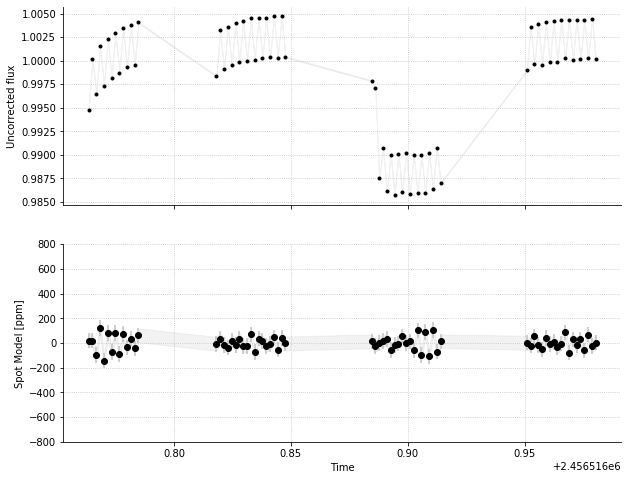

In [85]:

def gauss(p, x): 
    amp, t0, sigma = p
    return amp * np.exp(-0.5 * (x - t0)**2 / sigma**2)

visnum = [12, 13]
detrended_times = []
detrended_phase = []
detrended_flux = []
detrended_errors = []
spotted_flux = []
spot_params = []

initps = [[59, -20], 
          [59, -20]]
bounds = [[0, 90], 
          [-35, 0],
          ]#[0.05, 0.25]]
skip = 4
tau = 4.24e-3
spot_contrast= 0.8
spot_radius = 0.2

for vis, num, initp in zip([vis12, vis13], visnum, initps):

    s1 = (vis['spatial_scan'][skip:] == 0).astype(float)
    s2 = (vis['spatial_scan'][skip:] == 1).astype(float)
    orbit_inds = np.array([i == vis['orbit'][skip:] for i in np.unique(vis['orbit'])]).astype(float)
    times, fluxes, errors = vis['BJD_TDB'].data[skip:].copy(), vis['flux'].data[skip:].copy(), 1.0 * vis['err'].data[skip:].copy()

    errors = errors / np.median(fluxes)
    fluxes /= np.median(fluxes)

    transit_model = TransitModel(p, times, supersample_factor=10,
                                 exp_time=times[1]-times[0]).light_curve(p)
    
    t = np.array([(times - times[i.astype(bool)].mean()) * i for i in orbit_inds])
#     t = np.array([(times - times[i.astype(bool)][0]) * i for i in orbit_inds])

    phase = ((times - p.t0) % p.per) / p.per
    phase[phase >= 0.5] -= 1

    Omega_0 = np.diag(errors**2)
    inv_Omega_0 = np.linalg.inv(Omega_0)
    s = Star(spot_contrast, u_ld=[0, 0.28], phases=detrended_phase, rotation_period=125)

    X = np.vstack([1-np.exp(-t/tau), orbit_inds[0:3], # t, 
                   s1, s2, transit_model]).T
    XOX_inv = np.linalg.inv(X.T @ inv_Omega_0 @ X)
    c0 = XOX_inv @ X.T @ inv_Omega_0 @ fluxes
    
    initp = {"c{0:d}".format(i): c0[i] for i in range(len(c0))}
    
    # Define the model
    class MeanModel(Model):
        parameter_names = ["c{0:d}".format(i) for i in range(len(c0))]
        
        def get_value(self, t):
            c = np.array([getattr(self, 'c{0:d}'.format(i)) 
                          for i in range(len(c0))])
            return X @ c
        
    kernel = terms.Matern32Term(log_sigma=-20, log_rho=-2)
    gp = GP(kernel, mean=MeanModel(**initp), fit_mean=True, fit_white_noise=False)
    gp.compute(times, errors)

    # Define a cost function
    def neg_log_like(params):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(fluxes)

    all_initp = np.concatenate([[-10, -2], c0])
    bestp = fmin_powell(neg_log_like, all_initp)
    gp.set_parameter_vector(bestp)
    
    t = np.linspace(times.min(), times.max(), 1000)
    mu, var = gp.predict(fluxes, times, return_var=True)
    std = np.sqrt(var)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax[0].plot(times, fluxes, '.', color='k')
    ax[0].fill_between(times, mu-std, mu+std, color='silver', alpha=0.2)
    ax[0].set_ylabel('Uncorrected flux')
    ax[0].grid(ls=':', color='silver')
    
    ax[1].errorbar(times, 1e6 * (fluxes - mu), 1e6 * errors, 
                   fmt='o', color='k', ecolor='silver')
    ax[1].fill_between(times, 1e6 * (fluxes - mu-std), 1e6 * (fluxes - mu+std), color='silver', alpha=0.2)

    ax[1].set_ylim([-800, 800])
    ax[1].set_ylabel('Spot Model [ppm]')
    ax[1].set_xlabel('Time')
    ax[1].grid(ls=':', color='silver')    

    for axis in ax: 
        for sp in ['right', 'top']: 
            axis.spines[sp].set_visible(False)
#     fig.savefig('plots/visit{0}.pdf'.format(num), bbox_inches='tight')

    plt.show()
    spot_params.append(bestp)
    detrended_phase.append(phase)
    detrended_times.append(times)

    detrended_errors.append(errors)